/tmp/ipykernel_46533/2279335305.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT park_score FROM postcodes WHERE park_score IS NOT NULL AND park_score > 0.3", conn)


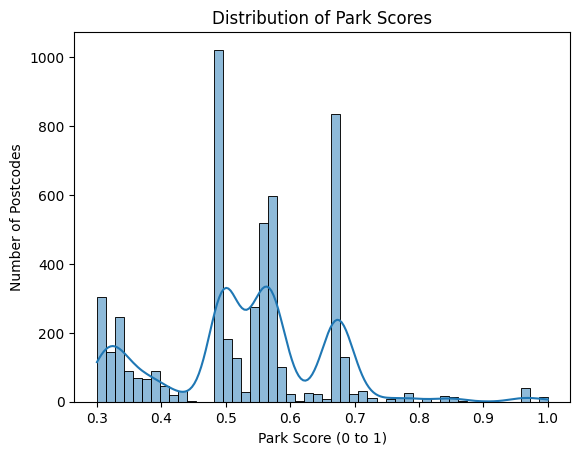

In [25]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml;

def load_config(path="../config/config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

config = load_config()
db = config['database']
conn = psycopg2.connect(
    dbname=db['dbname'],
    user=db['user'],
    password=db['password'],
    host=db['host'],
    port=db['port']
)

# Load data
df = pd.read_sql("SELECT park_score FROM postcodes WHERE park_score IS NOT NULL AND park_score > 0.3", conn)
conn.close()

# Plot histogram
sns.histplot(df['park_score'], bins=50, kde=True)
plt.title("Distribution of Park Scores")
plt.xlabel("Park Score (0 to 1)")
plt.ylabel("Number of Postcodes")
plt.show()


Showing the vast majority of postcodes have very little greenspace in comparison to the top, with about double the postcodes in the bottom 10% compared to the top 10%.

This makes sense as you'd expect areas with more green space to be less densely populated and therefore have fewer postcodes in general.

For scoring we'd probably want to exclude the bottom 50% or so in general to get a better distribution

/tmp/ipykernel_46533/788065439.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT park_sqm FROM postcodes WHERE park_score IS NOT NULL", conn)


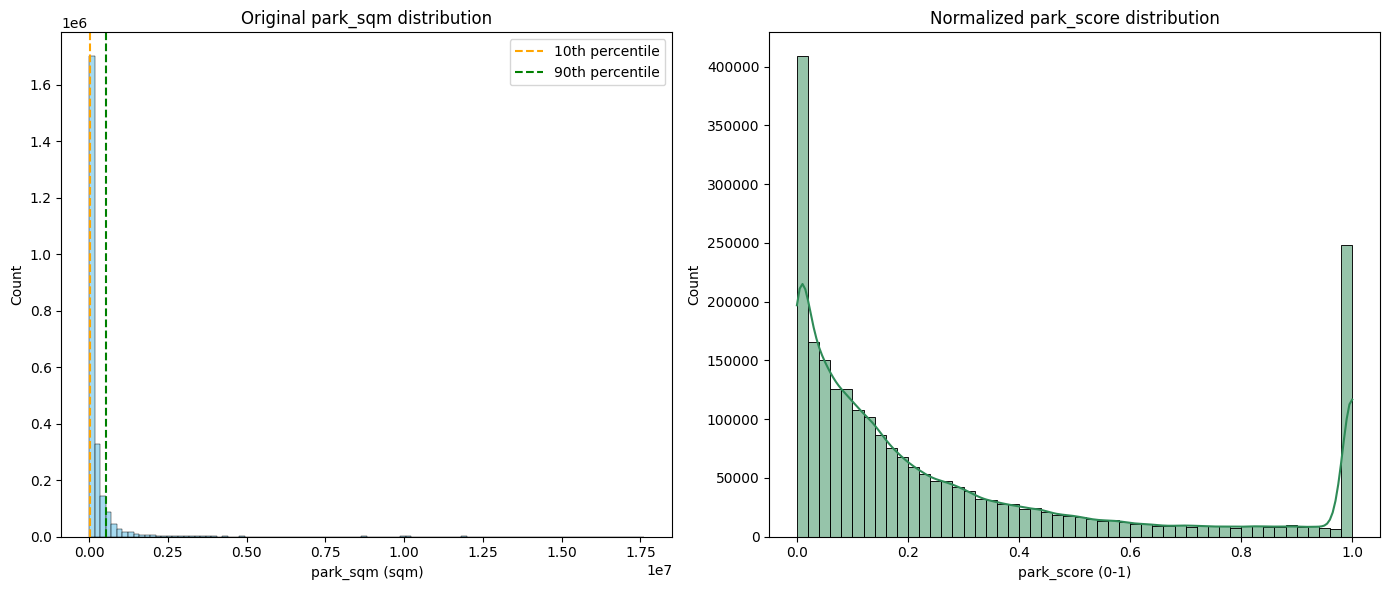

In [50]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import numpy as np

def load_config(path="../config/config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

config = load_config()
db = config['database']
conn = psycopg2.connect(
    dbname=db['dbname'],
    user=db['user'],
    password=db['password'],
    host=db['host'],
    port=db['port']
)

# Load data
df = pd.read_sql("SELECT park_sqm FROM postcodes WHERE park_score IS NOT NULL", conn)

park_sqm = df['park_sqm']

# Calculate percentiles
p10 = np.percentile(park_sqm, 10)
p90 = np.percentile(park_sqm, 90)

def normalize_with_clipping(x):
    if x <= p10:
        return 0.0
    elif x >= p90:
        return 1.0
    else:
        return (x - p10) / (p90 - p10)

# Apply normalization
df['park_score'] = park_sqm.apply(normalize_with_clipping)

# Plot original distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(park_sqm, bins=100, kde=False, color='skyblue')
plt.title('Original park_sqm distribution')
plt.xlabel('park_sqm (sqm)')
plt.ylabel('Count')
plt.axvline(p10, color='orange', linestyle='--', label='10th percentile')
plt.axvline(p90, color='green', linestyle='--', label='90th percentile')
plt.legend()

# Plot normalized distribution
plt.subplot(1, 2, 2)
sns.histplot(df['park_score'], bins=50, kde=True, color='seagreen')
plt.title('Normalized park_score distribution')
plt.xlabel('park_score (0-1)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


conn.close()

# Show distribution of greenspace, showing only the top 60% of postcodes

You can see that there's a few nice peaks at around .5 .6 and .7 scores

If we based our scoring on just the postcodes in this range then we'd get more useful results

/tmp/ipykernel_46533/3862799143.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT park_sqm FROM postcodes WHERE park_score IS NOT NULL", conn)


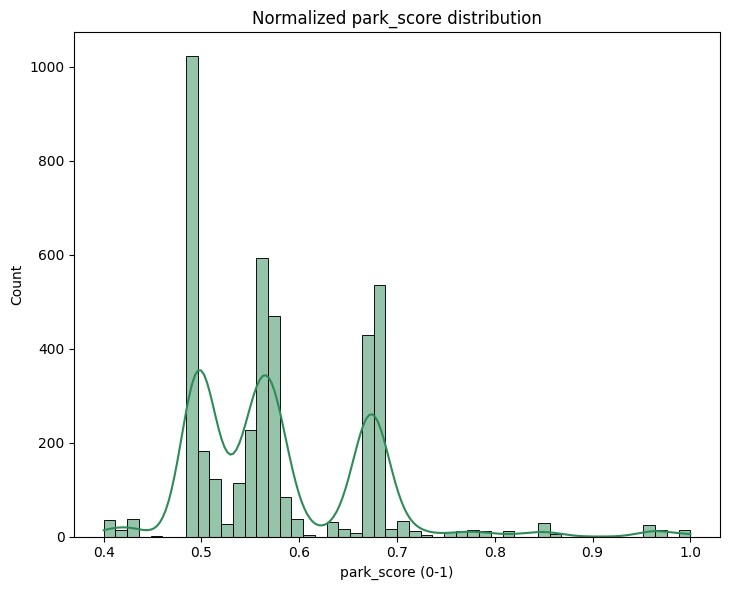

In [57]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import numpy as np

def load_config(path="../config/config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

config = load_config()
db = config['database']
conn = psycopg2.connect(
    dbname=db['dbname'],
    user=db['user'],
    password=db['password'],
    host=db['host'],
    port=db['port']
)

# Load data
df = pd.read_sql("SELECT park_sqm FROM postcodes WHERE park_score IS NOT NULL", conn)

park_sqm = df['park_sqm']

# Calculate percentiles
p10 = np.percentile(park_sqm, 0)
p90 = np.percentile(park_sqm, 100)

def normalize(x):
    return (x - p10) / (p90 - p10)

# # Apply normalization
df['park_score'] = park_sqm.apply(normalize)

# Apply normalization
score_no_zeros = df.loc[df['park_score'] > 0.4, 'park_score']

# Plot original distribution
plt.figure(figsize=(14, 6))
# Plot normalized distribution
plt.subplot(1, 2, 2)
sns.histplot(score_no_zeros, bins=50, kde=True, color='seagreen')
plt.title('Normalized park_score distribution')
plt.xlabel('park_score (0-1)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


conn.close()